# Assignment 1 : 
- Fashion-MNIST Dataset으로 MLP를 자유롭게 구현해보세요.
- PyTorch, TensorFlow 선택 자유
- Data 파일을 따로 드리지 않습니다. Dataset과 관련된 모듈을 활용하여 직접 해보시길 바랍니다.
- 공개된 코드를 사용하셔도 좋습니다. 이 경우 출처를 밝혀 주시기 바랍니다.

# Assignment 2 :
- 6주차 NN 기초 강의 과제였던 6_NeuralNetwork_HW.ipynb를 프레임워크로 구현
- PyTorch로 짠 예제 코드를 참고해주세요
- Batch Normalization, Dropout 등 NN 심화에서 다뤘던 내용을 활용




# Import library

In [4]:
import time
import numpy as np
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 데이터 다운받기 - normalize 적용(-1 ~ 1사이의 값으로)

torch.Size([60000, 28, 28])
torch.Size([60000])


/Users/daier/anaconda3/envs/testEnv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/daier/anaconda3/envs/testEnv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Text(0.5, 1.0, '4')

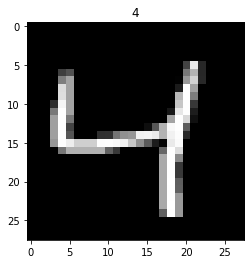

In [5]:
trainDataset = datasets.MNIST('../mnist_data/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(), # image to Tensor
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 기본으로 0,1 로 스케일링 해주기는 한다.
                             ])) 

testDataset = datasets.MNIST("../mnist_data/", 
                             download=False,
                             
                             train=False,
                             transform= transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307, ),(0.3081, ))
                           ]))

# 데이터 확인
print(trainDataset.train_data.size())
print(trainDataset.train_labels.size())

idx=2
plt.imshow(trainDataset.train_data[idx,:,:].numpy(), cmap='gray')
plt.title('%i' % trainDataset.train_labels[idx])

In [6]:
# Data Loader 
train_loader = torch.utils.data.DataLoader(dataset=trainDataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=32, shuffle=False)

In [17]:
train_loader.dataset.data[2]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,  67, 232,  39,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  62,  81,   0,   

# Modeling

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# nn은 레이어간 weight 공유, F는 단순히 연산만 
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__() # 상속받아 설계해야 한다.
        self.dense1 = nn.Linear(784, 512) # 첫번째 히든레이어 설정 (N, H)
        self.dense2 = nn.Linear(512, 10) # 두번째 히든레이어 (H, O)

    def forward(self, input):
        output = input.view(-1,784) # input값을 넣어 reshape 한다음 foward 과정
        output = self.dense1(output)
        output = self.dense2(output)
        return output

In [9]:
import torch.optim as optim

# use gpu -> .cuda() : model과 Variable에 쓰임
model = Network()

# 손실함수 : nn.CrossEntropyLoss()의 경우 기본적으로 LogSoftmax()가 내장
criterion = nn.CrossEntropyLoss()

# 최적화 함수 : parameters를 통해 parameter 할당가능 ,lr : learning_rate
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

# Train

In [18]:
from torch.autograd import Variable

def train(epoch):

    model.train()
    train_loss = 0
    train_acc = 0

    for data, label in train_loader:
        data, label = Variable(data), Variable(label)
        output = model(data) #forward 단계 실행 => output계산
        loss = criterion(output, label) # 모델에서 나온 output과 label을 이용해 loss 계산

        optimizer.zero_grad() # 갱신할 Variable들에 대한 모든 변화도를 0으로 만듬
        loss.backward() # 역전파 단계 실행. 모델의 Variable들에 대한 loss의 변화도를 계산합니다.
        optimizer.step() # 가중치 갱신

        train_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1] # 텐서 배열의 최대값이 들어가있는 label반환
        train_acc += pred.eq(label.data.view_as(pred)).sum() # pred와 라벨 비교

    train_loss /= len(train_loader.dataset)

    print('Train Epoch: {} Average loss: {:.4f} Accuracy : {:.4f}%)'.format(epoch, train_loss, 100. * train_acc / len(train_loader.dataset)))

# Test

In [19]:
def test():

    model.eval()
    test_loss = 0
    test_acc = 0

    for data, target in test_loader:
        # volatile=True no use backprob
        data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda()
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        test_acc += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%)'.format(test_loss, 100. * test_acc / len(test_loader.dataset)))